In [1]:
import sys
import os

# 添加 factor_evaluation.pyd 所在的目录到系统路径
pyd_path = r"D:\MG\！internship\！4L CAPITAL\因子评估器"
sys.path.append(pyd_path)

# 导入模块
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

In [4]:
def adaptive_kdj_factor(df, volatility_window=20):
    # 1. 增加价格过滤 - 避免在低波动期产生噪音
    returns = np.log(df['close']).diff()
    vol = returns.rolling(volatility_window, min_periods=1).std()
    vol = np.where(np.isinf(vol), np.nan, vol)  # 替换 inf
    vol = pd.Series(vol, index=df.index).ffill().bfill().fillna(0.01)
    
    # 2. 优化自适应逻辑 - 引入非线性缩放
    scaled_vol = (vol * 100).clip(5, 20)
    # 增加对高波动市场的敏感性
    n_period = np.where(scaled_vol > 15, 
                        scaled_vol * 1.4, 
                        scaled_vol * 0.6)
    n_period = np.clip(n_period, 5, 25).astype(int)
    
    # 3. 改进极值计算 - 增加权重衰减
    periods = list(range(5, 26))  # 5到25
    min_vals = []
    max_vals = []
    
    for p in periods:
        # 指数衰减加权最小值
        min_roll = df['low'].rolling(p, min_periods=1).min()
        min_ewm = min_roll.ewm(span=max(1, p//2), adjust=False).mean()
        min_vals.append(min_ewm)
        
        # 指数衰减加权最大值
        max_roll = df['high'].rolling(p, min_periods=1).max()
        max_ewm = max_roll.ewm(span=max(1, p//2), adjust=False).mean()
        max_vals.append(max_ewm)
    
    min_df = pd.DataFrame(dict(zip(periods, min_vals)), index=df.index)
    max_df = pd.DataFrame(dict(zip(periods, max_vals)), index=df.index)
    
    # 4. 动态选择窗口
    col_idx = (n_period - 5).clip(0, 20)
    row_idx = np.arange(len(df))
    low_min = min_df.values[row_idx, col_idx]
    high_max = max_df.values[row_idx, col_idx]
    
    # 5. 改进RSV计算 - 避免除以零
    denom = high_max - low_min
    # 使用 NumPy 的 where 替代 Pandas 的 replace
    denom = np.where(denom < 1e-5, 1e-5, denom)  # 避免除以零
    
    # 6. 改进RSV计算 - 增加平滑处理
    rsv = 100 * (df['close'].values - low_min) / denom
    rsv = np.clip(rsv, 0, 100)  # 限制在0-100范围内
    rsv = pd.Series(rsv, index=df.index).fillna(50)  # 填充缺失值为50
    
    # 7. 双EMA平滑
    fast_k = rsv.ewm(span=2, adjust=False, min_periods=1).mean()
    slow_k = fast_k.ewm(span=3, adjust=False, min_periods=1).mean()
    
    # 8. 改进中心化方法 - 使用滚动中位数避免极端值影响
    rolling_median = slow_k.rolling(100, min_periods=1).median().shift(1).fillna(50)
    
    # 9. 最终因子构建 - 添加方向控制和归一化
    factor = (slow_k - rolling_median)
    
    # 10. 增加趋势强化 - 结合动量方向
    momentum = df['close'].pct_change(3).fillna(0)
    factor = factor * (1 + np.sign(momentum) * 0.2)
    
    # 11. 最终归一化处理
    abs_mean = factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    factor = factor / abs_mean
    
    return factor

In [5]:
evaluator.set_factor(
    factor_data_or_func=adaptive_kdj_factor,
    factor_name='adaptive_kdj_factor'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.008029
   Rank_IC (Spearman): -0.015413
📊 信息比率:
   IR: 0.153227
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130650
   因子列: adaptive_kdj_factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


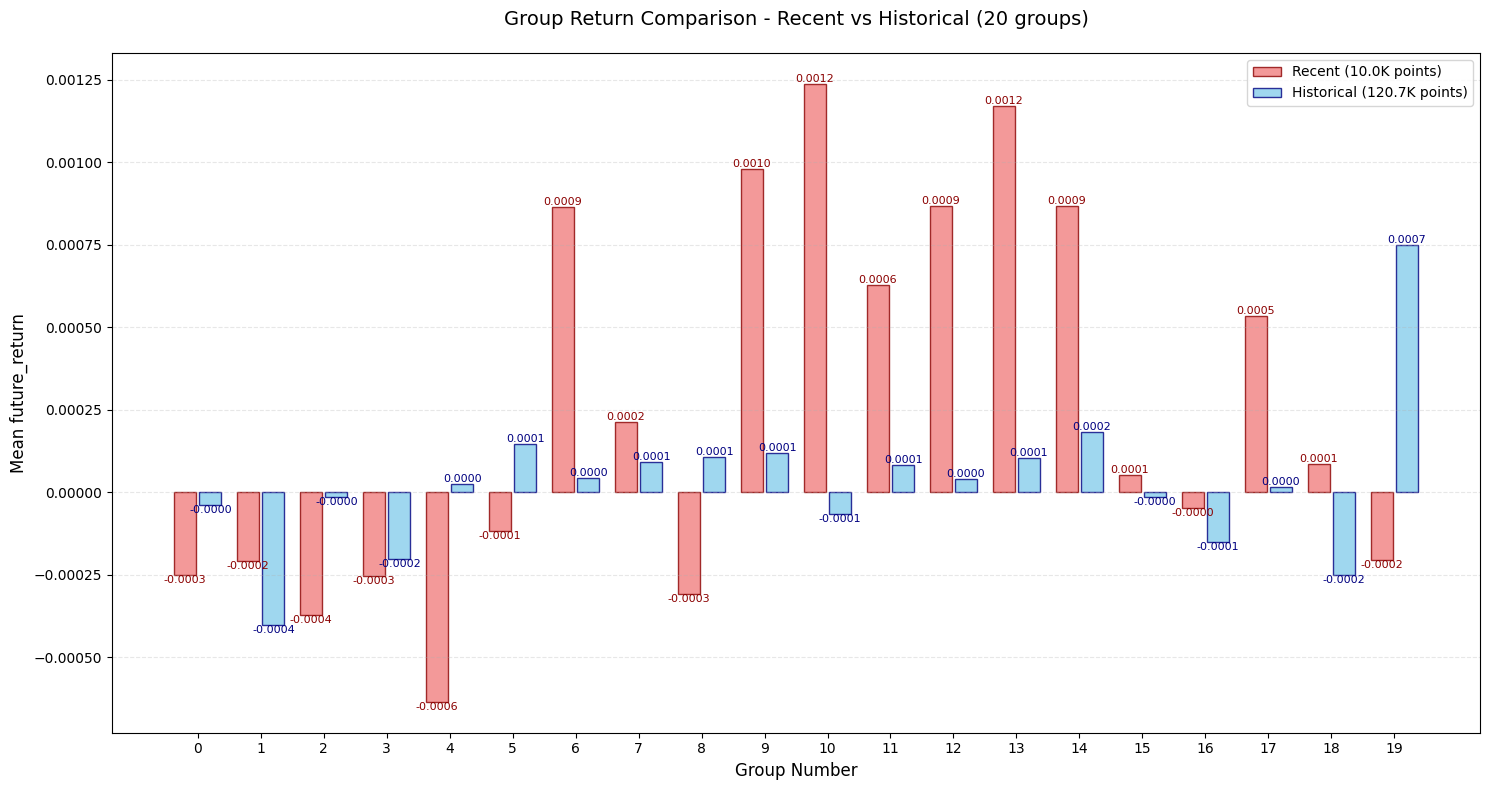

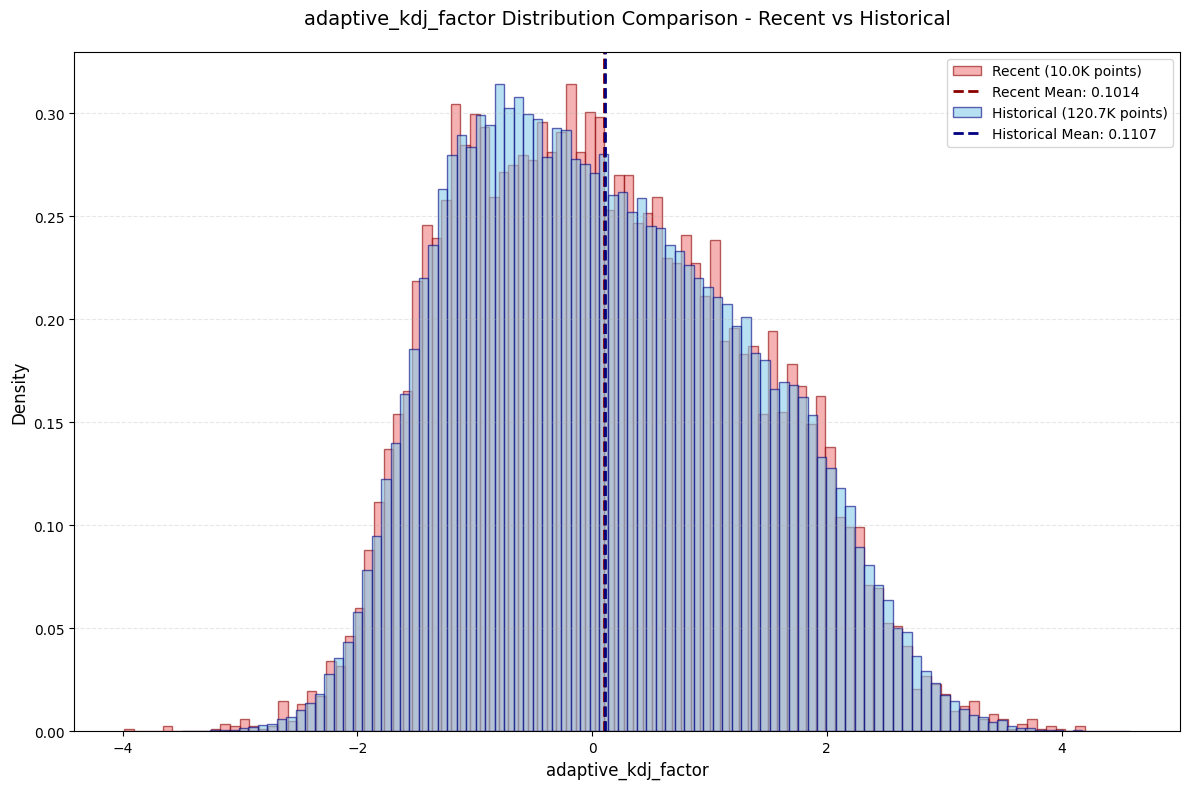

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [6]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)